# **_<div class="alert alert-info"><font color='darkred'> Cartografiando las Lomas</font></div>_**

## 1. Importación de las bibliotecas necesarias

In [1]:
import ee
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import geemap as emap
import geemap.colormaps as cm
Map = emap.Map()
Map.add_basemap('ROADMAP')
ee.Initialize()

## 2. Máximo NDVI entre 2000-2020

### 2.1 Algoritmo para procesar la media NDVI y SRTM

In [42]:
region = ee.FeatureCollection('users/geoyons/tugee/Lomas_Modis')

srtm = ee.Image("USGS/SRTMGL1_003").clip(region)
#maskDEM = SRTM.gte(150).And(SRTM.lte(1800))
palette = cm.palettes.dem

# Definimos la coleccion
collection = 'MODIS/006/MOD13Q1'

bands = ['NDVI']

def maskSQA(image):
    mask = image.select('SummaryQA').eq(0).Or(image.select('SummaryQA').eq(1))
    imageMask = image.updateMask(mask)
    return imageMask

ini_date = ['2000-07-01','2001-07-01','2002-07-01','2003-07-01','2004-07-01','2005-07-01','2006-07-01','2007-07-01',
           '2008-07-01','2009-07-01','2010-07-01','2011-07-01','2012-07-01','2013-07-01','2014-07-01','2015-07-01',
           '2016-07-01','2017-07-01','2018-07-01','2019-07-01','2020-07-01']

end_date = ['2000-10-30','2001-10-30','2002-10-30','2003-10-30','2004-10-30','2005-10-30','2006-10-30','2007-10-30',
           '2008-10-30','2009-10-30','2010-10-30','2011-10-30','2012-10-30','2013-10-30','2014-10-30','2015-10-30',
           '2016-10-30','2017-10-30','2018-10-30','2019-10-30','2020-10-30']

ndviM = ee.List([])

for i in np.arange(0, len(ini_date), 1):
    
    col = ee.ImageCollection(collection)\
        .filterDate(ini_date[i],end_date[i])\
        .filterBounds(region)\
        .map(maskSQA)\
        .reduce(ee.Reducer.max())\
        .select([0], bands)
    freq = col.select('NDVI').divide(10000).clip(region)
    ndviM = ndviM.add(freq)

# Coleccion de imagenes
ndvi = ee.ImageCollection.fromImages(ndviM).reduce(ee.Reducer.mean())

# Definimos los parametros de visualizacion
visParams = {
  'bands': ['NDVI_mean'],
  'min': 0,
  'max': 0.45,
  'palette': ['FFFFFF','CC9966','CC9900','996600', '33CC00', '009900','006600']
}

slope = ee.Terrain.slope(srtm)
Map.addLayer(srtm, {'min': 20,'max': 2000, 'palette': palette}, 'SRTM', True)
Map.addLayer(ndvi, visParams, 'NDVI', True)
Map

Map(bottom=140208.0, center=[-12.044692844011117, -76.8109130859375], controls=(WidgetControl(options=['positi…

In [43]:
# Descargar directamente a Google Drive
task = ee.batch.Export.image(srtm.divide(1), 
                              'SRTM_RegionLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()
# Descargar directamente a Google Drive
task = ee.batch.Export.image(ndvi.divide(1), 
                              'NDVI_MEDIA_RegioLomas', 
                              {'region': region.geometry(),
                               'scale': 250,
                               'maxPixels': 1e13,
                               'folder': 'MOD13Q1_NDVI',
                               'fileFormat': 'GeoTIFF',
                               'crs': 'EPSG:4326'})
task.start()

### 2.2 Correlación entre NDVI y SRTM

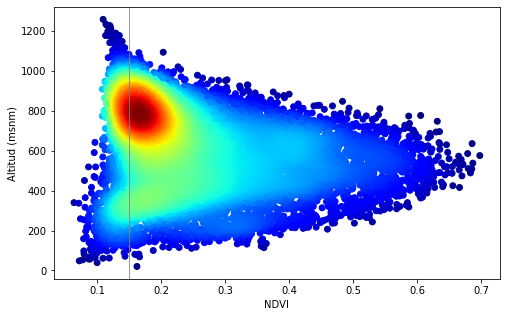

In [49]:
path = r'F:\ConsultoriaPNUD\Data\MapLomas\MOD13Q1_NDVI'
os.chdir(path)

srtm = rasterio.open('SRTM_RegionLomas.tif').read()
ndvi = rasterio.open('NDVI_MEDIA_RegioLomas.tif').read()

n = ndvi.ravel()
m = srtm.ravel()
x = n[~np.isnan(n)]
y = m[~np.isnan(m)]

# Calcula la densidad de punto
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Ordena los puntos por densidad
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(x, y, c=z, s=35, cmap='jet')
axes.set_ylabel('Altitud (msnm)')
axes.set_xlabel('NDVI')
axes.axvline(x =0.15, color='grey', linewidth=0.8, label='Área de la Loma')
plt.show()